### We want to see if there is a correlation in the performance of the specific $w$ and $h(x)$ with the PR dimension of the kernel matrix.

April 28th 2019 (BP): We will use the gaussian formulation to generate our bandpass weights and the DFT matrix to generate our data

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import dask

In [ ]:
from estimator import RFClassifier, relu, bp_weights_gaus, bp_weights
from data_fns import pure_sine_dft

In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

In [ ]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    # PR dimension of test data
    K = clf.transform(X_test)
    w, _ = la.eig(K.T @ K)
    PR = np.sum(w) ** 2 / np.sum(w ** 2)
    # norm of the coefficient
    clf_coef_norm = la.norm(clf.clf.coef_)
    return [PR, clf_coef_norm, 1 - clf.score(X_test, y_test)]

In [14]:
def plot_results(results, title):
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)

    ax1.set_title('PR dimension', fontsize=16)
    ax2.set_title('clf weights norm', fontsize=16)
    ax3.set_title('Clf error', fontsize=16)
    for (wt, val) in results.items():
        mean_pr, mean_wt_norm, mean_err = np.split(np.mean(val, axis=1), 3, axis=1)
        std_pr, std_wt_norm, std_err = np.split(np.std(val, axis=1), 3, axis=1)
        ax3.errorbar(n_features, mean_err, yerr=std_err.flatten(), fmt='--o', label=wt, markersize=4, lw=2)
        ax1.errorbar(n_features, mean_pr, yerr=std_pr.flatten(), fmt='--o', label=wt,  markersize=4, lw=2)
        ax2.errorbar(n_features, mean_wt_norm, yerr=std_wt_norm.flatten(), fmt='--o', label=wt, markersize=4, lw=2)
    ax1.legend(fontsize=10)
    ax2.legend(fontsize=10)
    ax3.legend(fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

In [52]:
# generate data
nPoints, fs, sig_dur = 5000, 1500, 0.1
k, a = 5, 0.8
X, y = pure_sine_dft(nPoints, fs, k, sig_dur, a, seed=20)

N = X.shape[1]
f_signal = int(k / sig_dur)
print('signal frequency=%d Hz' % f_signal)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

signal frequency=50 Hz


In [53]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


__Compare the performance and PR dimension of various $w$'s without nonlinearity.__

In [26]:
%%time
lowcut, highcut = f_signal - 30, f_signal + 30
f = lambda M, N: bp_weights(M, N, lowcut=lowcut, highcut=highcut, fs=fs)
f_gaus = lambda M, N: bp_weights_gaus(M, N, lowcut=lowcut, highcut=highcut, fs=fs)
h = lambda x: np.cos(x)

weights = [('bandpass', f), ('bandpass_gaus', f_gaus),
           ('unimodal', None), ('white noise', None), ('identity', None)]
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

CPU times: user 34.7 s, sys: 8.73 s, total: 43.4 s
Wall time: 4min 19s


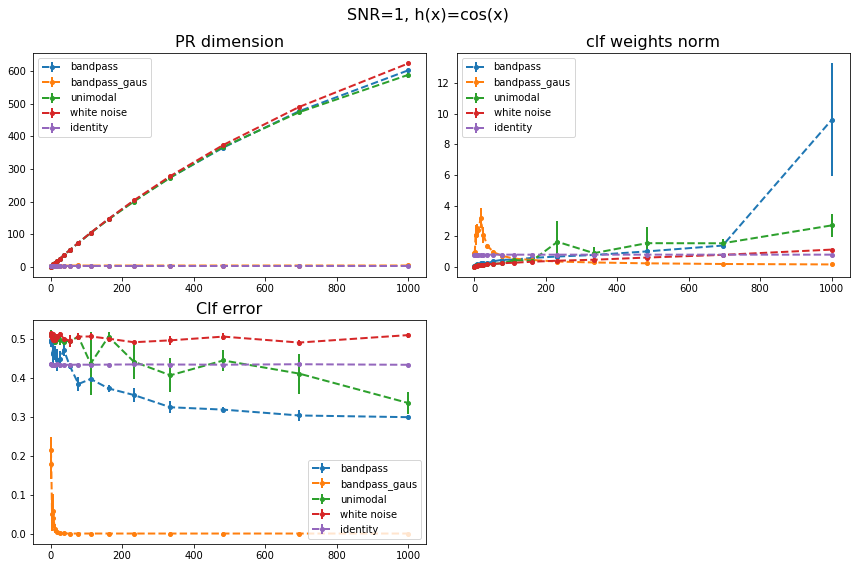

In [28]:
snr = a ** 2 / (1 - a ** 2)
plot_results(results, 'SNR=%d, h(x)=cos(x)' % snr)
plt.savefig('figures/rand_classification/dft_data/clf_dim_cos_nonlin.png')

__Compare the performance and PR dimension of bandpass weights with different non-linearities__

In [54]:
%%time 
lowcut, highcut = f_signal - 30, f_signal + 30
f_gaus = lambda M, N: bp_weights_gaus(M, N, lowcut=lowcut, highcut=highcut, fs=fs)

non_lins = [('relu', relu), ('cosine', lambda x: np.cos(x)), ('xsq', lambda x : x ** 2),
           ('id', lambda x: x)]
results = {nl:[] for (nl, func) in non_lins}
for n in n_features:
    for (nl, h) in non_lins:
        params = {'width': n, 'weights': 'bandpass gaus', 'weight_fun': f_gaus, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[nl].append(np.real(dask.compute(*lazy_results)))

CPU times: user 24.3 s, sys: 7.55 s, total: 31.9 s
Wall time: 3min 6s


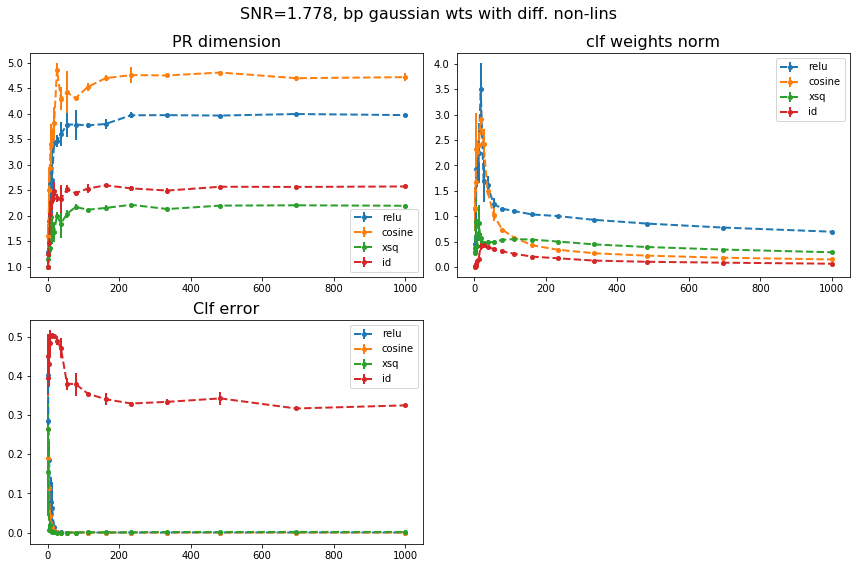

In [55]:
snr = a ** 2 / (1 - a ** 2)
plot_results(results, 'SNR=%0.3f, bp gaussian wts with diff. non-lins' % snr)
# plt.savefig('figures/rand_classification/dft_data/clf_dim_bpgaus_nonlin_a=%0.2f.png' % a)

In [20]:
ls figures/rand_classification/dft_data/

clf_dim_id_nonlin.png


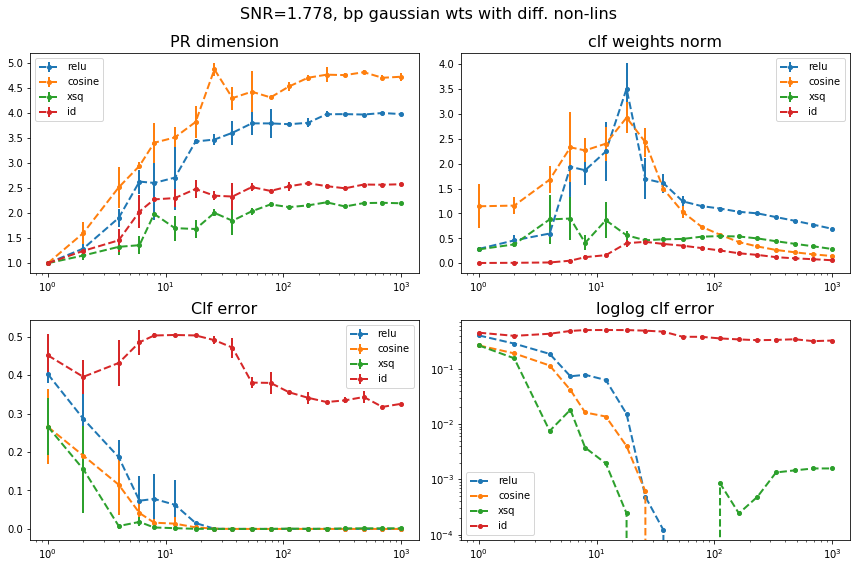

In [63]:
title = 'SNR=%0.3f, bp gaussian wts with diff. non-lins' % snr
fig = plt.figure(figsize=(12, 8))
plt.suptitle(title, fontsize=16)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('PR dimension', fontsize=16)
ax2.set_title('clf weights norm', fontsize=16)
ax3.set_title('Clf error', fontsize=16)
ax4.set_title('loglog clf error', fontsize=16)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax4.set_xscale('log')
for (wt, val) in results.items():
    mean_pr, mean_wt_norm, mean_err = np.split(np.mean(val, axis=1), 3, axis=1)
    std_pr, std_wt_norm, std_err = np.split(np.std(val, axis=1), 3, axis=1)
    ax3.errorbar(n_features, mean_err, yerr=std_err.flatten(), fmt='--o', label=wt, markersize=4, lw=2)
    ax1.errorbar(n_features, mean_pr, yerr=std_pr.flatten(), fmt='--o', label=wt,  markersize=4, lw=2)
    ax2.errorbar(n_features, mean_wt_norm, yerr=std_wt_norm.flatten(), fmt='--o', label=wt, markersize=4, lw=2)
    ax4.loglog(n_features, mean_err, '--o', label=wt, markersize=4, lw=2)
# ax3.set_xlim([0, 100])
ax1.legend(fontsize=10)
ax2.legend(fontsize=10)
ax3.legend(fontsize=10)
ax4.legend(fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)